# Computing the Value of Information for supporting system design

Intro text ...

#### Setup

In [1]:
import os
import yaml
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats
from scipy.stats import linregress

from models import run_model, sample_posterior
from functools import partial
from utils import get_Gurobi_WLS_env, fmt_design_results, fmt_voi_results, plot_cost_dist

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps as cmaps

In [2]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)
random.seed(11)

In [3]:
with open(os.path.join('resources','defaults.yaml'), 'r') as f:
    defaults = yaml.safe_load(f)

v = defaults['variables']

solar_years = list(defaults['static']['solar_years'])
load_years = list(defaults['static']['load_years'])

# define statistical model parameters
msr_error = 0.025 # hyperparameter of likeilhood model
# number of samples to draw
prior_samples = 50
posterior_samples = 10

Wrap useful data structuring into function for clearer syntax later on

In [4]:
def build_scenarios(load_samples):

    n = len(load_samples)

    scenarios = {
        'mean_load': load_samples,
        'solar_year': random.choice(solar_years, n),
        'load_year': random.choice(load_years, n),
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=v['battery_efficiency'], scale=v['battery_efficiency_std'], size=n),
        'battery_cost': stats.truncnorm.rvs(-2, 2, loc=v['battery_cost'], scale=v['battery_cost_std'], size=n),
    }

    return scenarios

#### Prior design

In [5]:
# the syntax is a bit odd here, but we need to do the sampling
# exactly the same as Notebook 1 to make sure we get the same results
random.seed(11)

# sample from prior distributions
prior_scenarios = {
    'mean_load': stats.truncnorm.rvs(-2, 2, loc=v['mean_load'], scale=v['mean_load_std'], size=prior_samples),
    'solar_year': random.choice(solar_years, prior_samples),
    'load_year': random.choice(load_years, prior_samples),
    'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=v['battery_efficiency'], scale=v['battery_efficiency_std'], size=prior_samples),
    'battery_cost': stats.truncnorm.rvs(-2, 2, loc=v['battery_cost'], scale=v['battery_cost_std'], size=prior_samples),
}

random.seed(11)
thetas = stats.truncnorm.rvs(-2, 2, loc=v['mean_load'], scale=v['mean_load_std'], size=prior_samples)
zs = stats.norm.rvs(loc=thetas, scale=thetas*msr_error)

In [6]:
print(np.mean(thetas))
print(np.mean(zs))

98.94428494505537
99.00315295163476


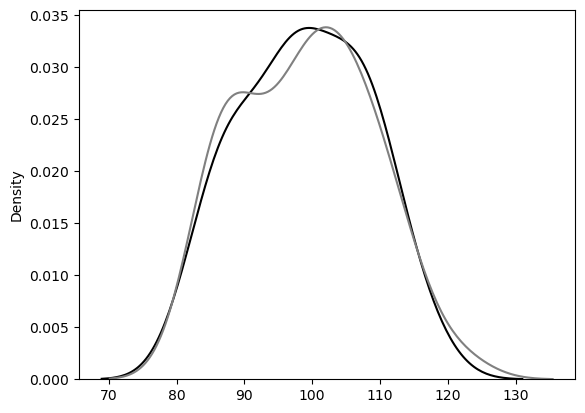

In [7]:
sns.kdeplot(thetas, label='mean load', color='k')
sns.kdeplot(zs, label='measured load', color='gray')
plt.show()

This difference in means between $\theta$ and $z$ is an issue with our small sample size (50). It will lead to a basis where the posterior solutions will have slightly higher costs on average, as the scenarios that are sampled will end up having a slightly larger mean load, and so greater operational costs. As a result, the VoI will be slightly underestimated.

In [8]:
# perform design using SP
prior_results = run_model(
    solar_capacity=None,
    battery_capacity=None,
    **prior_scenarios
)

print(fmt_design_results(prior_results))

Parameter         Unit      Value
----------------  ------  -------
Solar capacity    kWp       806.6
Battery capacity  kWh       428.5
Total cost        £k/yr     139.9
CAPEX             £k/yr      90.5
OPEX              £k/yr      49.4


#### Design with perfect information

In [9]:
PIresults = []

for i in tqdm(range(prior_samples), desc='Solving posterior problems'):

    # grab each scenario individually
    # we assume we know the true value of the uncertainties
    scenario = {
        key: [prior_scenarios[key][i]]\
            for key in prior_scenarios.keys()
    }

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenario
    )

    PIresults.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

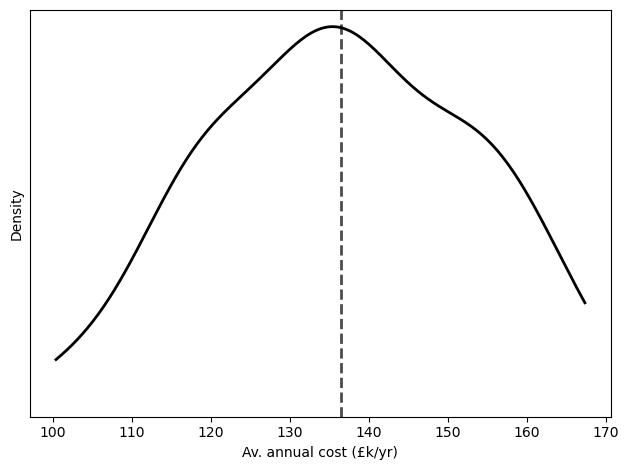

In [10]:
plot_cost_dist([r['total'] for r in PIresults])

In [11]:
print(fmt_voi_results(prior_results, PIresults))


    Prior cost: £139.94/yr
    Posterior cost: £136.41/yr
    VoI: £3.53/yr
    VoI percent: 2.52%
    


... but obviously this isn't actually achievable ...

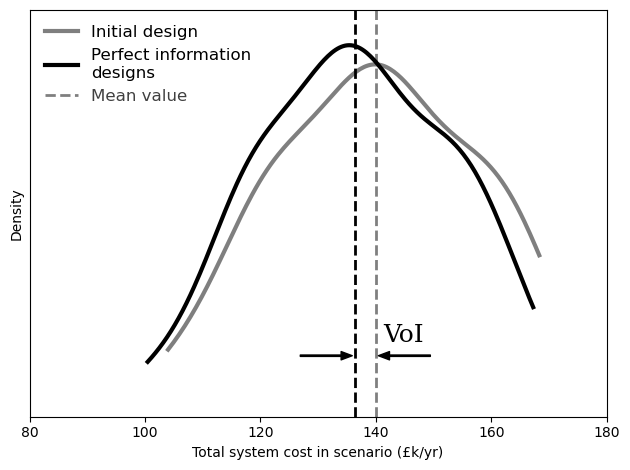

In [22]:
# compare the costs of each design over the scenarios
prior_scenario_costs = [np.sum(list(d.values())) for d in prior_results['scenario_costs']]
posterior_scenario_costs = [r['total'] for r in PIresults]

fig, ax = plt.subplots()
sns.kdeplot(np.array(prior_scenario_costs)/1e3, label='Initial design', ax=ax, c='k', alpha=0.5, lw=3, cut=0)
sns.kdeplot(np.array(posterior_scenario_costs)/1e3, label='Perfect information\ndesigns', ax=ax, c='k', lw=3, cut=0)
ymax = ax.get_ylim()[1]*1.05
plt.vlines(np.mean(prior_scenario_costs)/1e3, 0, ymax, colors='k', alpha=0.5, linestyles='dashed', lw=2)
plt.vlines(np.mean(posterior_scenario_costs)/1e3, 0, ymax, colors='k', linestyles='dashed', lw=2)
plt.vlines(np.mean(prior_scenario_costs)/1e3, 0, 0, colors='k', alpha=0.5, linestyles='dashed', lw=2, label='Mean value')
plt.annotate('', xy=(np.mean(prior_scenario_costs)/1e3, ymax*0.15), xytext=(np.mean(prior_scenario_costs)/1e3 + 10, ymax*0.15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=8))
plt.annotate('', xy=(np.mean(posterior_scenario_costs)/1e3, ymax*0.15), xytext=(np.mean(posterior_scenario_costs)/1e3 - 10, ymax*0.15),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=8))
plt.text(np.mean(prior_scenario_costs)*1.035/1e3, ymax*0.2, 'VoI', va='center', ha='center', fontsize=18, fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', boxstyle='square,pad=0.125'))

xlim = ax.get_xlim()
plt.xlim(round(xlim[0]*0.8,-1), round(xlim[1]*1.025,-1))
plt.xlabel('Total system cost in scenario (£k/yr)')
plt.ylim(0, ymax)
ax.get_yaxis().set_ticks([])
leg = plt.legend(fontsize=12, frameon=False, loc='upper left')
leg.get_texts()[-1].set_color((0,0,0,0.75))
plt.tight_layout()
plt.savefig(os.path.join('plots','perfect_info_costs_comparison.pdf'), transparent=True)
plt.show()

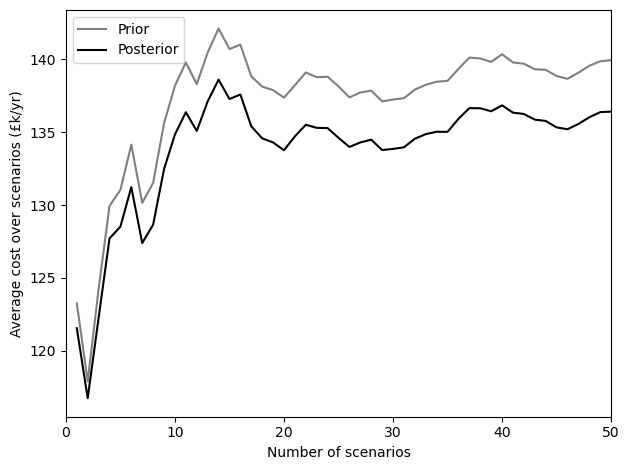

In [13]:
# plot convergence of utility estimates
xs = np.arange(1,prior_samples+1)

fig, ax = plt.subplots()

ax.plot(xs, [np.mean(prior_scenario_costs[:i])/1e3 for i in range(1,prior_samples+1)], c='k', alpha=0.5, label='Prior')
ax.plot(xs, [np.mean(posterior_scenario_costs[:i])/1e3 for i in range(1,prior_samples+1)], c='k', label=f'Posterior')

ax.set_xlabel('Number of scenarios')
ax.set_ylabel('Average cost over scenarios (£k/yr)')
plt.xlim(0,prior_samples)

plt.legend()
plt.tight_layout()
plt.show()

#### Design with partial perfect information (known load)

In [14]:
PPIresults = []

for theta in tqdm(thetas, desc='Solving posterior problems'):

    # sample from other uncertainties for each known load value
    vscenarios = build_scenarios([theta]*posterior_samples)

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **vscenarios
    )

    PPIresults.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

... notice how this calculation takes waaaay longer than the EVPI ...

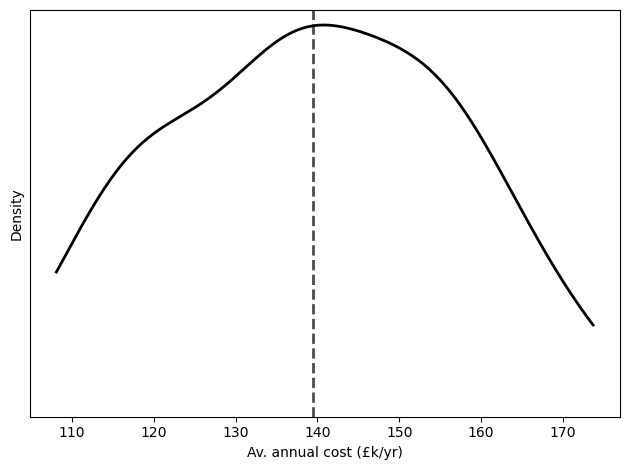

In [15]:
plot_cost_dist([r['total'] for r in PPIresults])

In [16]:
print(fmt_voi_results(prior_results, PPIresults))


    Prior cost: £139.94/yr
    Posterior cost: £139.41/yr
    VoI: £0.54/yr
    VoI percent: 0.38%
    


#### Imperfect information (reduced load uncertainty)

In [17]:
IIresults = []

random.seed(11)

for z in tqdm(zs, desc='Solving posterior problems'):

    # sample from posterior load distribution
    varthetas = sample_posterior(z=z, nsamples=posterior_samples, msr_error=msr_error)

    # sample values for all other uncertainties from their prior distributions
    vscenarios = build_scenarios(varthetas)

    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **vscenarios
    )

    IIresults.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

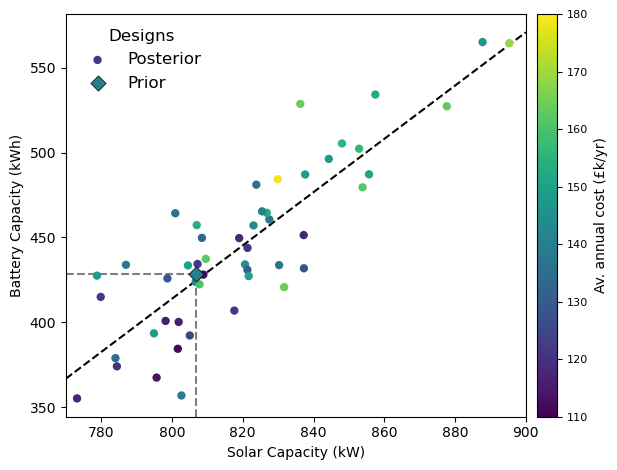

In [18]:
# compare posterior designs to prior design

solar_caps = [r['solar_capacity'] for r in IIresults]
battery_caps = [r['battery_capacity'] for r in IIresults]
costs = [s['total']/1e3 for s in IIresults]

reg = linregress(solar_caps,battery_caps)

fig, ax = plt.subplots()

norm = plt.Normalize(round(0.975*min(costs),-1), round(1.025*max(costs),-1))
cmap = cmaps['viridis']

xmin = round(0.99*min(solar_caps),-1)
xmax = round(1.01*max(solar_caps),-1)
reg_xs = np.linspace(xmin, xmax, 100)
ax.plot(reg_xs, reg.slope*reg_xs + reg.intercept, 'k--', alpha=1, label='__nolegend__', zorder=0)

# posterior
ax.scatter(
    x=solar_caps,
    y=battery_caps,
    c=costs,
    norm=norm,
    cmap=cmap,
    label='Posterior',
    marker='o',
    alpha=1,
    lw=0,
)
# prior
ax.scatter(
    x=prior_results['solar_capacity'],
    y=prior_results['battery_capacity'],
    c=[prior_results['total']/1e3],
    norm=norm,
    cmap=cmap,
    label='Prior',
    marker='D',
    s=60,
    edgecolors='k',
    alpha=1,
    lw=0.5,
)

# guide lines
ymin,ymax = ax.get_ylim()
plt.vlines(prior_results['solar_capacity'], ymin, prior_results['battery_capacity'],
            colors='k', alpha=0.5, linestyles='dashed', lw=1.5, zorder=0)
plt.hlines(prior_results['battery_capacity'], xmin, prior_results['solar_capacity'],
            colors='k', alpha=0.5, linestyles='dashed', lw=1.5, zorder=0)

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm), ax=ax, pad=0.02)
cbar.set_label('Av. annual cost (£k/yr)')
cbar.ax.tick_params(labelsize=8)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Battery Capacity (kWh)')

leg = plt.legend(fontsize=12, frameon=False, loc='upper left')
leg.set_title("Designs", prop={'size': 12})

plt.tight_layout()
plt.savefig(os.path.join('plots','prior_vs_posterior_designs.pdf'), transparent=True)
plt.show()

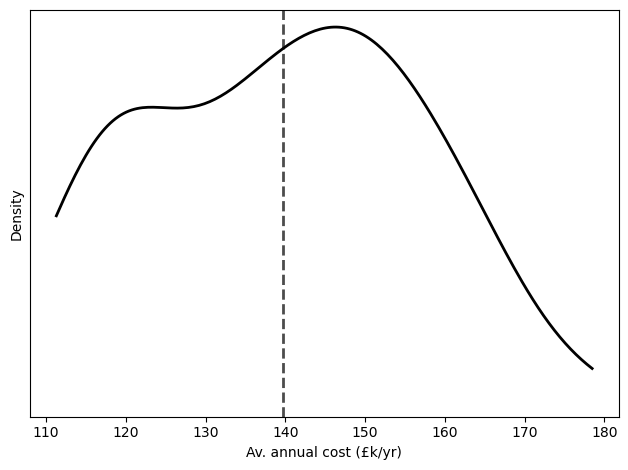

In [19]:
plot_cost_dist([r['total'] for r in IIresults])

In [20]:
print(fmt_voi_results(prior_results, IIresults))


    Prior cost: £139.94/yr
    Posterior cost: £139.68/yr
    VoI: £0.26/yr
    VoI percent: 0.19%
    
